In [14]:
import mesa
import numpy as np
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

In [15]:
class CleaningAgent(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        self.movements = 0

    def step(self):
        x, y = self.pos
        cellContent = self.model.dirtyGrid[x][y]

        if cellContent == 1:
            self.model.dirtyGrid[x][y] = 0
        else:
            neighbors = self.model.grid.get_neighborhood(
                pos=self.pos,
                moore=True,
                include_center=False
            )
            if neighbors:
                newPos = self.random.choice(neighbors)
                self.model.grid.move_agent(self, newPos)
                self.movements += 1

class RoomToClean(mesa.Model):
    def __init__(self, m, n, numAgent, dirtyPercentage, maxTime):
        super().__init__()
        self.numAgent = numAgent
        self.maxRounds = maxTime
        self.actualWeight = 0

        self.grid = MultiGrid(m, n, torus=False)
        self.dirtyGrid = np.where(np.random.rand(m, n) < dirtyPercentage, 1, 0)

        for _ in range(self.numAgent):
            agent = CleaningAgent(self)
            self.grid.place_agent(agent, pos=(1, 1))

        self.datacollector = DataCollector(
            model_reporters={"DirtyCells": lambda m: 1.0 - np.mean(m.dirtyGrid)},
            agent_reporters={"Movements": lambda a: a.movements}
        )

    def step(self):
        self.datacollector.collect(self)
        if self.actualWeight >= self.maxRounds or (1.0 - np.mean(self.dirtyGrid)) == 1.0:
            self.running = False
        else:
            self.agents.shuffle_do("step")
            self.actualWeight += 1

Values: m = 10, n = 10, Agents = 3, dirtyPercentaje = 0.5, maxTime = 60

In [16]:
if __name__ == "__main__":
    m, n = 10, 10
    numAgent = 3
    dirtyPercentage = 0.5
    maxTime = 60

    print(f"Starting simulation with parameters: {m}x{n} grid, {numAgent} agents, {dirtyPercentage*100}% dirty cells, max time {maxTime} steps.")

    model = RoomToClean(m, n, numAgent, dirtyPercentage, maxTime)
    model.run_model()

    requiredTime = model.actualWeight
    print(f"\nSimulation finished in {requiredTime} steps.")

    finalPercentageCleaned = (1.0 - np.mean(model.dirtyGrid)) * 100
    print(f"Final percentage of cleaned cells: {finalPercentageCleaned:.2f}%")

    dataAgent = model.datacollector.get_agent_vars_dataframe()
    last_step_index = requiredTime - 1
    finalMovements = dataAgent.xs(last_step_index, level="Step")["Movements"].sum() if last_step_index >= 0 else 0
    print(f"Total movements made by all agents: {finalMovements}")


Starting simulation with parameters: 10x10 grid, 3 agents, 50.0% dirty cells, max time 60 steps.

Simulation finished in 60 steps.
Final percentage of cleaned cells: 73.00%
Total movements made by all agents: 149


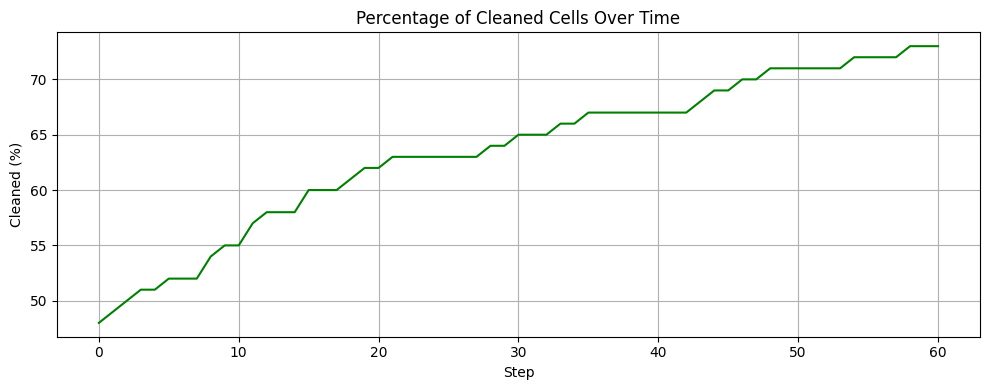

In [17]:
import matplotlib.pyplot as plt

model_data = model.datacollector.get_model_vars_dataframe()

plt.figure(figsize=(10, 4))
plt.plot(model_data['DirtyCells'] * 100, color='green')
plt.title('Percentage of Cleaned Cells Over Time')
plt.xlabel('Step')
plt.ylabel('Cleaned (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


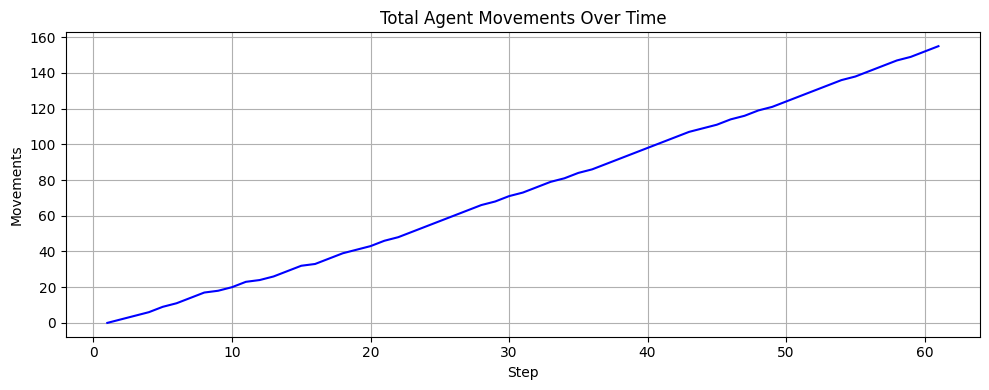

In [18]:
dataAgent = model.datacollector.get_agent_vars_dataframe()
movement_sum = dataAgent.groupby('Step')['Movements'].sum()

plt.figure(figsize=(10, 4))
plt.plot(movement_sum, color='blue')
plt.title('Total Agent Movements Over Time')
plt.xlabel('Step')
plt.ylabel('Movements')
plt.grid(True)
plt.tight_layout()
plt.show()


Finished simulation for 3 agents: Steps=60, Cleaned=60.00%, Movements=151
Finished simulation for 4 agents: Steps=60, Cleaned=73.00%, Movements=202
Finished simulation for 5 agents: Steps=60, Cleaned=74.00%, Movements=261
Finished simulation for 6 agents: Steps=60, Cleaned=91.00%, Movements=311
Finished simulation for 7 agents: Steps=60, Cleaned=91.00%, Movements=366
Finished simulation for 8 agents: Steps=60, Cleaned=92.00%, Movements=419
Finished simulation for 9 agents: Steps=60, Cleaned=91.00%, Movements=477

Summary:
Agents | Steps | Cleaned_% | Total_Movements
     3 |    60 |     60.00 |             151
     4 |    60 |     73.00 |             202
     5 |    60 |     74.00 |             261
     6 |    60 |     91.00 |             311
     7 |    60 |     91.00 |             366
     8 |    60 |     92.00 |             419
     9 |    60 |     91.00 |             477


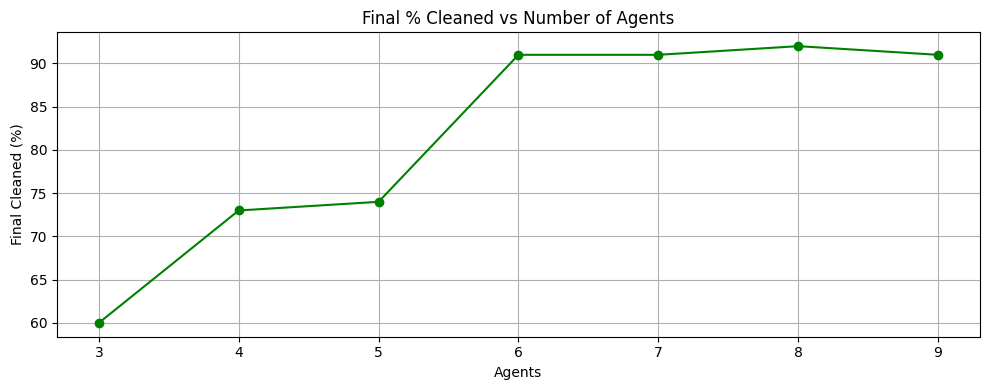

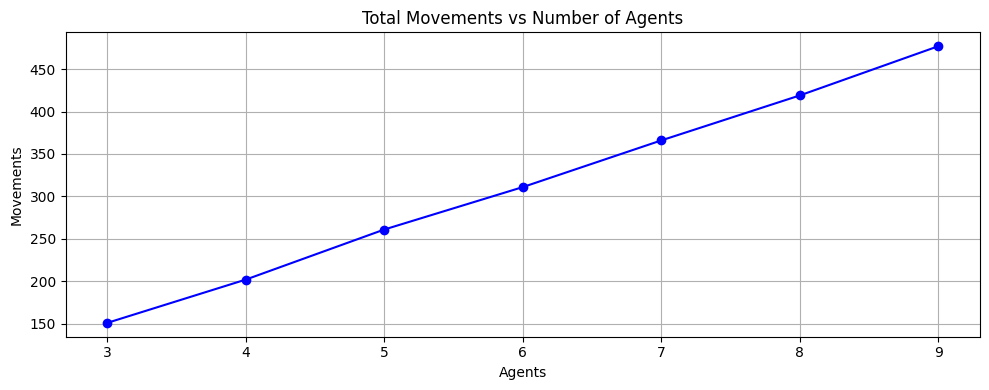

In [19]:
import matplotlib.pyplot as plt

m, n = 10, 10
agent_counts = list(range(3, 10))  
dirtyPercentage = 0.5
maxTime = 60

results = []

def run_sim(num_agents: int):
    model = RoomToClean(m, n, num_agents, dirtyPercentage, maxTime)
    model.run_model()

    requiredTime = model.actualWeight
    finalPercentageCleaned = (1.0 - np.mean(model.dirtyGrid)) * 100

    dataAgent = model.datacollector.get_agent_vars_dataframe()
    last_step_index = requiredTime - 1
    if last_step_index >= 0:
        try:
            finalMovements = dataAgent.xs(last_step_index, level="Step")["Movements"].sum()
        except Exception:
            if "Step" in getattr(dataAgent.index, "names", []):
                finalMovements = dataAgent.groupby(level="Step")["Movements"].sum().iloc[-1]
            else:
                finalMovements = dataAgent["Movements"].iloc[-1] if not dataAgent.empty else 0
    else:
        finalMovements = 0

    return num_agents, requiredTime, finalPercentageCleaned, finalMovements

steps_list = []
cleaned_list = []
moves_list = []

for a in agent_counts:
    agents, steps, cleaned, moves = run_sim(a)
    results.append((agents, steps, cleaned, moves))
    steps_list.append(steps)
    cleaned_list.append(cleaned)
    moves_list.append(moves)
    print(f"Finished simulation for {agents} agents: Steps={steps}, Cleaned={cleaned:.2f}%, Movements={moves}")

print("\nSummary:")
print("Agents | Steps | Cleaned_% | Total_Movements")
for agents, steps, cleaned, moves in results:
    print(f"{agents:>6} | {steps:>5} | {cleaned:>9.2f} | {moves:>15}")

plt.figure(figsize=(10,4))
plt.plot(agent_counts, cleaned_list, marker='o', color='green')
plt.title('Final % Cleaned vs Number of Agents')
plt.xlabel('Agents')
plt.ylabel('Final Cleaned (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(agent_counts, moves_list, marker='o', color='blue')
plt.title('Total Movements vs Number of Agents')
plt.xlabel('Agents')
plt.ylabel('Movements')
plt.grid(True)
plt.tight_layout()
plt.show()

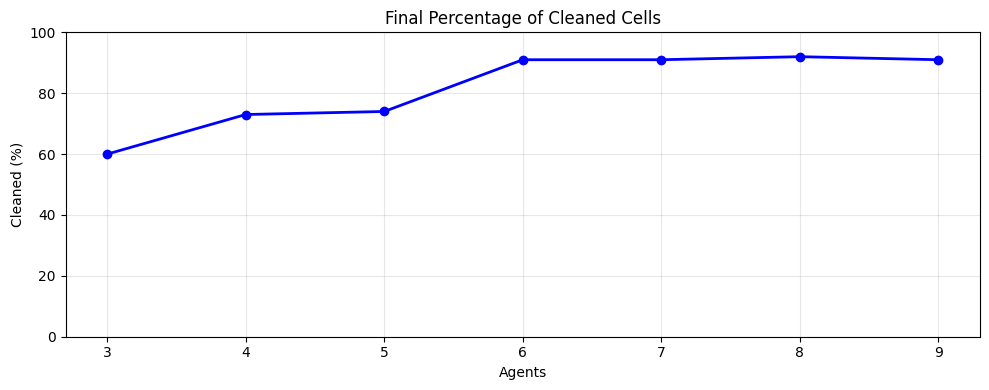

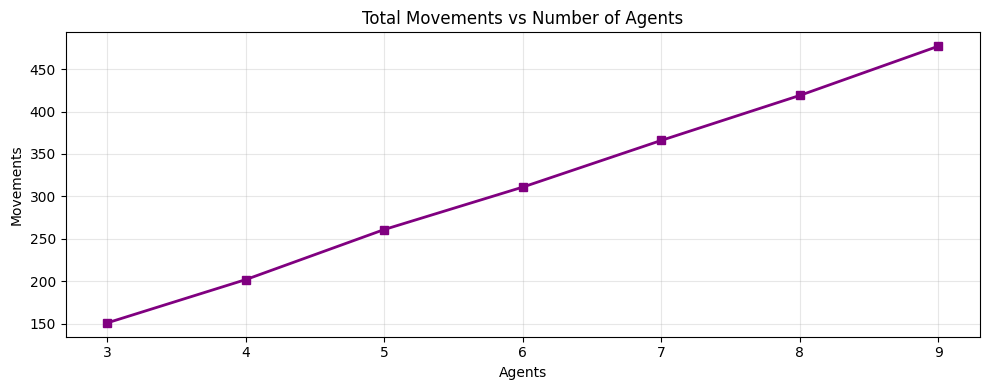

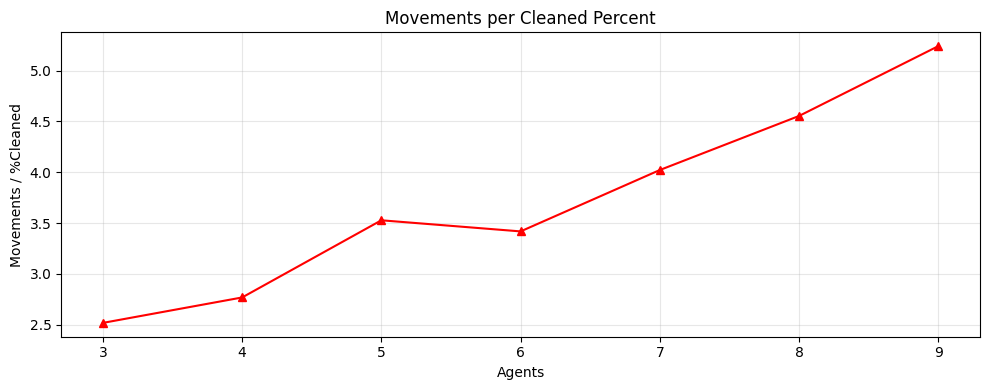

In [20]:
import matplotlib.pyplot as plt
import numpy as np

columns = ["Agents", "Steps", "Cleaned_%", "Total_Movements"]
try:
    import pandas as pd
    metrics_df = pd.DataFrame(results, columns=columns)
except Exception:
    metrics_df = None
    agents_list = [r[0] for r in results]
    steps_list = [r[1] for r in results]
    cleaned_list = [r[2] for r in results]
    moves_list = [r[3] for r in results]

if metrics_df is not None:
    agents_arr = metrics_df['Agents'].to_numpy()
    steps_arr = metrics_df['Steps'].to_numpy()
    cleaned_arr = metrics_df['Cleaned_%'].to_numpy()
    moves_arr = metrics_df['Total_Movements'].to_numpy()
else:
    agents_arr = np.array(agents_list)
    steps_arr = np.array(steps_list)
    cleaned_arr = np.array(cleaned_list)
    moves_arr = np.array(moves_list)


plt.figure(figsize=(10,4))
plt.plot(agents_arr, cleaned_arr, marker='o', linewidth=2, color='blue')
plt.title('Final Percentage of Cleaned Cells')
plt.xlabel('Agents')
plt.ylabel('Cleaned (%)')
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(agents_arr, moves_arr, marker='s', linewidth=2, color='purple')
plt.title('Total Movements vs Number of Agents')
plt.xlabel('Agents')
plt.ylabel('Movements')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
movements_per_percent = moves_arr / np.maximum(cleaned_arr, 1)
plt.plot(agents_arr, movements_per_percent, marker='^', color='red')
plt.title('Movements per Cleaned Percent')
plt.xlabel('Agents')
plt.ylabel('Movements / %Cleaned')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if metrics_df is not None:
    metrics_df